In [72]:
import pandas as pd
import pymongo
import re
import operator
import nltk
import numpy as np
import pylab
import matplotlib.pyplot as plt
import os
from collections import Counter
from scipy.stats import binom
from textblob import TextBlob
import pandas as pd
from wordcloud import WordCloud, STOPWORDS 

plt.style.use('fivethirtyeight')

client = pymongo.MongoClient (host="da1.eecs.utk.edu")
db = client ['GDA']
coll = db ['NYT']

stop_words = nltk.corpus.stopwords.words('english') + ['timesmachine','Archives','Credit','New','York','Times','full','text','Mr','Mrs','article',
 'view','said','would','also','ut', '\'re','.', ',', '--', '\'s', '?', ')', '(', ':', '\'','continue','reading',
 '\"', '-', '}', '{', '&', '|', u'\u2014','one','','im' ]

# We also want to remove special characters, quotes, etc. from each word
def cleanWord (w):
    # r in r'[.,"\']' tells to treat \ as a regular character 
    # but we need to escape ' with \'
    # any character between the brackets [] is to be removed 
    wn = re.sub('[,"\.\'&\|:@>*;/=��]', "", w)
    # get rid of numbers
    re.sub('^[0-9\.]*$', "", wn)
    return wn.lower()

def get_total_count():
    print('Total NYT articles {0}'.format(str(coll.count_documents({}))))

def article_count_by_generation():
    boom=[]
    genX=[]
    genY=[]
    genZ=[]

    cursor = coll.aggregate( [{ '$match': { 'year' : { '$gte' : 1960, '$lte' : 1964 } } },{'$count': 'Article Count'}] )
    boom = list(cursor)
    cursor = coll.aggregate( [{ '$match': { 'year' : { '$gte' : 1965, '$lte' : 1979 } } },{'$count': 'Article Count'}] )
    genX = list(cursor)
    cursor = coll.aggregate( [{ '$match': { 'year' : { '$gte' : 1980, '$lte' : 1999 } } },{'$count': 'Article Count'}] )
    genY = list(cursor)
    cursor = coll.aggregate( [{ '$match': { 'year' : { '$gte' : 2000, '$lte' : 2019 } } },{'$count': 'Article Count'}] )
    genZ = list(cursor)

    df = pd.DataFrame(boom+genX+genY+genZ, index =['Boomers: 1960 to 1964',
                                                   'Gen X:   1965 to 1979',
                                                   'Gen Y:   1980 to 2000',
                                                   'Gen Z:   2000 to 2019'],
                      columns =['Article Count']) 
    display(df)
    display(df.sum())

def get_dataframe_by_year(year):
    cursor = coll.aggregate( [{ '$match': { 'year' : { '$eq' : year} } }] )
    df = pd.DataFrame(list(cursor))
    return df

def Diff(list1, list2): 
    return list(set(list1) - set(list2)) 

def Same(list1, list2, list3, list4):
    return list(set(list1) & set(list2) & set(list3) & set(list4)) 

def Sym(list1, list2):
    return list(set(list1) ^ set(list2))

def get_text_by_generation():
    boom = ''
    genX = ''
    genY = ''
    genZ = ''

    cursor = coll.aggregate( [{ '$match': { 'year' : { '$gte' : 1960, '$lte' : 1964 } } }] )
    for record in cursor:
        boom = boom + record ['text']
      
    cursor = coll.aggregate( [{ '$match': { 'year' : { '$gte' : 1965, '$lte' : 1979 } } }] )
    for record in cursor:
        genX = genX + record ['text']
        
    cursor = coll.aggregate( [{ '$match': { 'year' : { '$gte' : 1980, '$lte' : 1999 } } }] )
    for record in cursor:
        genY = genY + record ['text']
        
    cursor = coll.aggregate( [{ '$match': { 'year' : { '$gte' : 2000, '$lte' : 2019 } } }] )
    for record in cursor:
        genZ = genZ + record ['text']
        
    return boom, genX, genY, genZ, boom+genX+genY+genZ

def get_text_by_year(year):
    ret_text = ''

    cursor = coll.aggregate( [{ '$match': { 'year' : { '$eq' : year} } }] )
    for record in cursor:
        ret_text = ret_text + record ['text']
        
    return ret_text

def process_data(text, size): 
    # split string into an array of words using any sequence of spaces "\s+" 
    wds = re .split('\s+',text)
    
    # remove periods, commas, etc stuck to the edges of words
    for i in range(len(wds)):
        wds [i] = cleanWord (wds [i])
    
    # If satisfied with results, lets go to the next step: calculate frequencies
    # We can write a loop to create a dictionary, but 
    # there is a special function for everything in python
    # in particular for counting frequencies (like function table() in R)
    wf = Counter (wds)
    
    # Remove stop words from the dictionary wf
    for k in stop_words:
        wf. pop(k, None)
        
    #how many regular words in the document?
    tw = 0
    for w in wf:
        tw += wf[w]   
    
    # Get ordered list
    wfs = sorted (wf .items(), key = operator.itemgetter(1), reverse=True)
    ml = min(len(wfs),size)
    
    only = []
    for i in range (size):
        only.append(wfs[i][0])  
    
    #Reverse the list
    return (wfs [0:ml][::-1], tw, only)

%matplotlib inline
def plotTwoLists (list1, list2, title, subtitle1, subtitle2):
    plt.style.use('seaborn-dark')
    f = plt.figure (figsize=(10, 6))
    # this is painfully tedious....
    f .suptitle (title, fontsize=20)
    ax = f.add_subplot(111)
    ax .spines ['top'] .set_color ('none')
    ax .spines ['bottom'] .set_color ('none')
    ax .spines ['left'] .set_color ('none')
    ax .spines ['right'] .set_color ('none')
    ax .tick_params (labelcolor='w', top=False, bottom=False, left=False, right=False, labelsize=20)

    # Create two subplots, this is the first one
    ax1 = f .add_subplot (121)
    plt .subplots_adjust (wspace=.5)

    pos = np .arange (len(list1)+1) 
    ax1.title.set_text(subtitle1)
    ax1 .tick_params (axis='both', which='major', labelsize=14)
    pylab .yticks (pos, [ x [0] for x in list1 ])
    ax1 .barh (range(len(list1)), [ x [1] for x in list1 ], align='center',color='#1D1A1D')

    ax2 = f .add_subplot (122)
    ax2 .tick_params (axis='both', which='major', labelsize=14)
    pos = np .arange (len(list2)+1)
    ax2.title.set_text(subtitle2)
    pylab .yticks (pos, [ x [0] for x in list2 ])
    ax2 .barh (range (len(list2)), [ x [1] for x in list2 ], align='center',color='#1D1A1D')
    
    plt.savefig(title +'.png')

def binomial_plot(n_values,p_values,title,lables,colors,low,high):
    fig, ax = plt.subplots(1, 1)
    #x = np.arange(low,high)
    for (n, p, lb, clr) in zip(n_values, p_values, lables, colors):
        dist = binom(n, p)
        plt.plot(x, dist.pmf(x), color=clr, label=lb,)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.title(title)
    plt.legend()
    plt.savefig(title +'.png')

In [2]:
# Populate data 
bm, X, Y, Z, all_text  = get_text_by_generation()

In [3]:
#Text Blob Analysis
print('Text Blob - Boomer')
bm_tude_blob = TextBlob(bm)
print('Text Blob - GenX')
X_tude_blob = TextBlob(X)
print('Text Blob - GenY')
Y_tude_blob = TextBlob(Y)
print('Text Blob - GenZ')
Z_tude_blob = TextBlob(Z)

#sentiment
#Return a tuple of form (polarity, subjectivity ) where polarity is a float within the range [-1.0, 1.0] 
#and subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
#Return type:	namedtuple of the form Sentiment(polarity, subjectivity)

#sentiment_assessments
#Return a tuple of form (polarity, subjectivity, assessments ) where polarity is a float within the range 
#[-1.0, 1.0], subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is 
#very subjective, and assessments is a list of polarity and subjectivity scores for the assessed tokens.
#Return type:	namedtuple of the form ``Sentiment(polarity, subjectivity,assessments)

Text Blob - Boomer
Text Blob - GenX
Text Blob - GenY
Text Blob - GenZ


In [4]:
df_tude = pd.DataFrame(columns=['Start Year', 'End Year', 'Polarity','Subjectivity', 'Generation'])


df_tude = df_tude.append({'Start Year':1960, 'End Year':1964, 'Year Range':'1960-1964',                         
                          'Polarity':bm_tude_blob.polarity,
                          'Subjectivity':bm_tude_blob.subjectivity,
                          'Generation':'Boomers'}, ignore_index=True)
print('Text Blob - Boomer')
df_tude = df_tude.append({'Start Year':1965, 'End Year':1979, 'Year Range':'1965-1979',               
                          'Polarity':X_tude_blob.polarity,
                          'Subjectivity':X_tude_blob.subjectivity,
                          'Generation':'GenX'}, ignore_index=True)

print('Text Blob - GenX')
df_tude = df_tude.append({'Start Year':1980, 'End Year':1999, 'Year Range':'1980-1999', 
                          'Polarity':Y_tude_blob.polarity,
                          'Subjectivity':Y_tude_blob.subjectivity,
                          'Generation':'GenY'}, ignore_index=True)

print('Text Blob - GenY')
df_tude = df_tude.append({'Start Year':2000, 'End Year':2019, 'Year Range':'2000-2019', 
                          'Polarity':Z_tude_blob.polarity,
                          'Subjectivity':Z_tude_blob.subjectivity,
                          'Generation':'GenZ'}, ignore_index=True)
print('Text Blob - GenZ')

Text Blob - Boomer
Text Blob - GenX
Text Blob - GenY
Text Blob - GenZ


,Start Year,End Year,Polarity,Subjectivity,Generation,Year Range
0,1960,1964,0.114099,0.419705,Boomers,1960-1964
1,1965,1979,0.098561,0.423770,GenX,1965-1979
2,1980,1999,0.099086,0.420175,GenY,1980-1999
3,2000,2019,0.106348,0.418874,GenZ,2000-2019


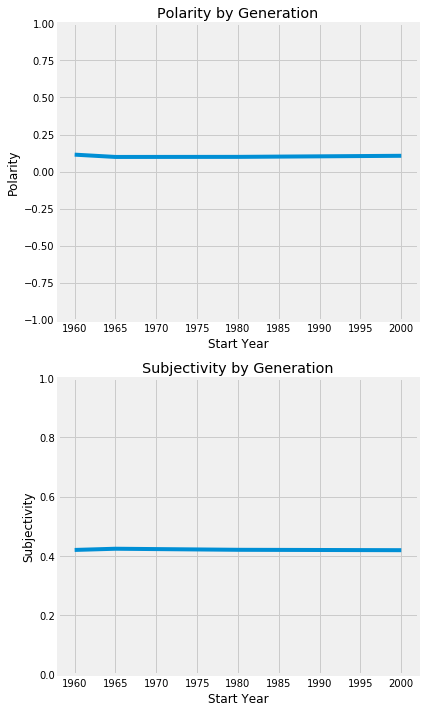

In [11]:
display(df_tude)

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
axes[0].plot(df_tude['Start Year'],df_tude['Polarity'])
axes[0].set_title('Polarity by Generation')
axes[0].set_xlabel('Start Year')
axes[0].set_ylabel('Polarity')
axes[0].set_ylim(-1, 1)
axes[1].plot(df_tude['Start Year'],df_tude['Subjectivity'])
axes[1].set_title('Subjectivity by Generation')
axes[1].set_xlabel('Start Year')
axes[1].set_ylabel('Subjectivity')
axes[1].set_ylim(0, 1)
fig.tight_layout()
fig.savefig('Text_analysis_generation.png',dpi=300)

In [14]:
article_count_by_generation()
print('Text Blob - Boomer')
bm_words = bm_tude_blob.words
bm_words_count = len(bm_words)
print('Text Blob - GenX')
X_words = X_tude_blob.words
X_words_count = len(X_words)
print('Text Blob - GenY')
Y_words = Y_tude_blob.words
Y_words_count = len(Y_words)
print('Text Blob - GenZ')
Z_words = Z_tude_blob.words
Z_words_count = len(Z_words)
all_words_count = bm_words_count+X_words_count+Y_words_count+Z_words_count

print('Total Boomer words {}'.format(bm_words_count))
print('Total GenX words {}'.format(X_words_count))
print('Total GenY words {}'.format(Y_words_count))
print('Total GenZ words {}'.format(Z_words_count))
print('Total words {}'.format(all_words_count))

,Article Count
Boomers: 1960 to 1964,647
Gen X: 1965 to 1979,7245
Gen Y: 1980 to 2000,14451
Gen Z: 2000 to 2019,19447


Article Count    41790
dtype: int64

Text Blob - Boomer
Text Blob - GenX
Text Blob - GenY
Text Blob - GenZ
Total Boomer words 168700
Total GenX words 2456610
Total GenY words 5392032
Total GenZ words 18209297
Total words 26226639


In [7]:
years = list(range(1960, 2020))

df_tude_year = pd.DataFrame(columns=['Year', 'Polarity', 'Subjectivity'])
for y in years:
    print(y)
    text_blob = TextBlob(get_text_by_year(y))    
    df_tude_year = df_tude_year.append({'Year':y,                         
                          'Polarity':text_blob.polarity,
                          'Subjectivity':text_blob.subjectivity}, ignore_index=True)

1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


,Year,Polarity,Subjectivity
0,1960.0,0.247993,0.506060
1,1961.0,0.168165,0.514824
2,1962.0,0.246322,0.490923
3,1963.0,0.097177,0.497973
4,1964.0,0.109608,0.413214
5,1965.0,0.185210,0.522638
6,1966.0,0.262733,0.510525
7,1967.0,0.209070,0.477354
8,1968.0,0.178193,0.452925
9,1969.0,0.234009,0.488780


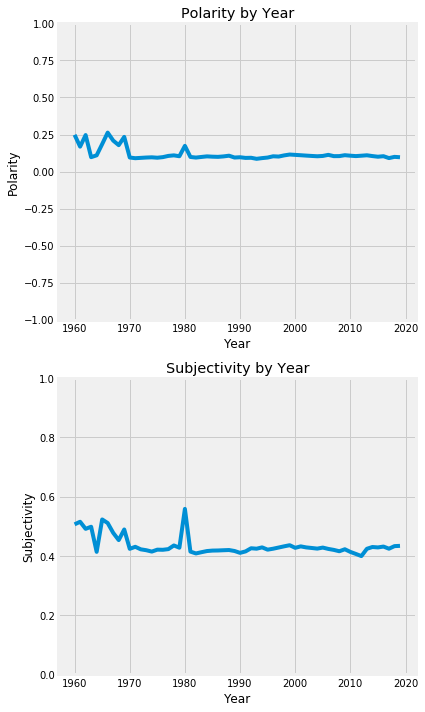

In [12]:
display(df_tude_year)

fig2, axes2 = plt.subplots(2, 1, figsize=(6, 10))
axes2[0].plot(df_tude_year['Year'],df_tude_year['Polarity'])
axes2[0].set_title('Polarity by Year')
axes2[0].set_xlabel('Year')
axes2[0].set_ylabel('Polarity')
axes2[0].set_ylim(-1, 1)
axes2[1].plot(df_tude_year['Year'],df_tude_year['Subjectivity'])
axes2[1].set_title('Subjectivity by Year')
axes2[1].set_xlabel('Year')
axes2[1].set_ylabel('Subjectivity')
axes2[1].set_ylim(0, 1)
fig2.tight_layout()
fig2.savefig('Text_analysis_year.png',dpi=300)

In [15]:
df_count_year = pd.DataFrame(columns=['Year', 'Word Count'])
for y in years:
    print(y)  
    text_blob = TextBlob(get_text_by_year(y))
    text_blob_words = text_blob.words
    df_count_year = df_count_year.append({'Year':y,                         
                          'Word Count':len(text_blob_words)}, ignore_index=True)

1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


,Year,Word Count
0,1960,2899
1,1961,2053
2,1962,1176
3,1963,4250
4,1964,158325
5,1965,889
6,1966,1473
7,1967,794
8,1968,1051
9,1969,1510


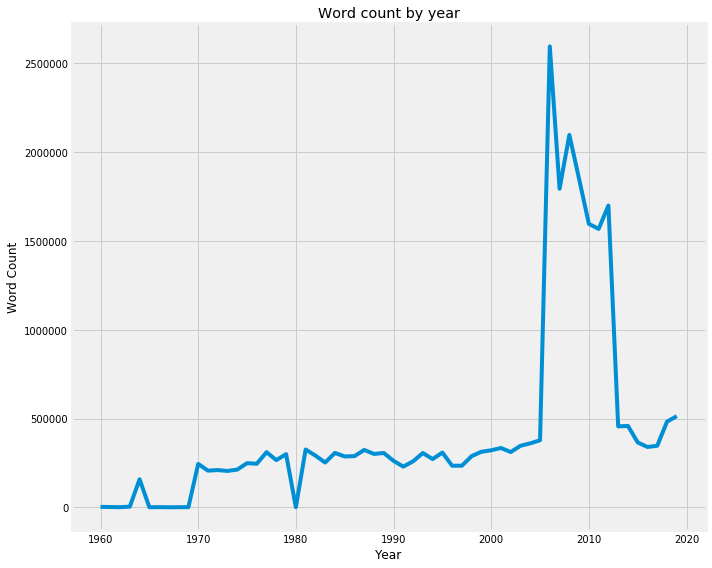

In [30]:
display(df_count_year)

word_plot = df_count_year.plot(x='Year',y='Word Count', title='Word count by year',legend=False,figsize=(10, 8))

word_plot.set_ylabel('Word Count')
word_fig = word_plot.get_figure()
word_fig.tight_layout()
word_fig.savefig('Word_count_year.png',dpi=300)

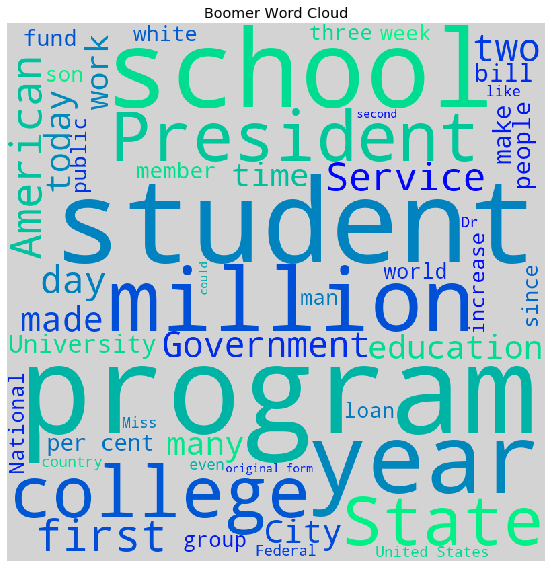

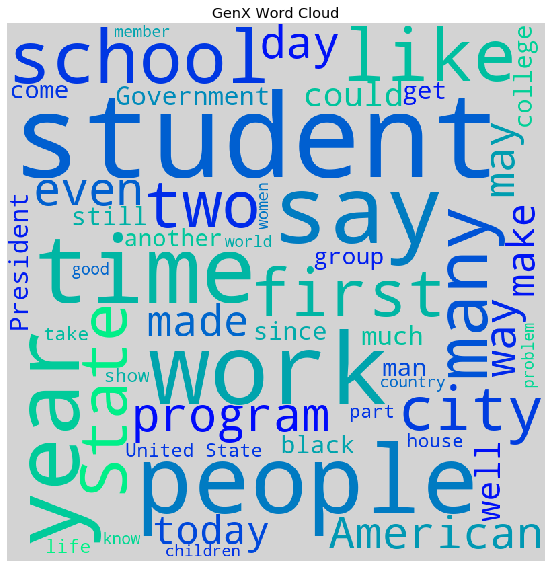

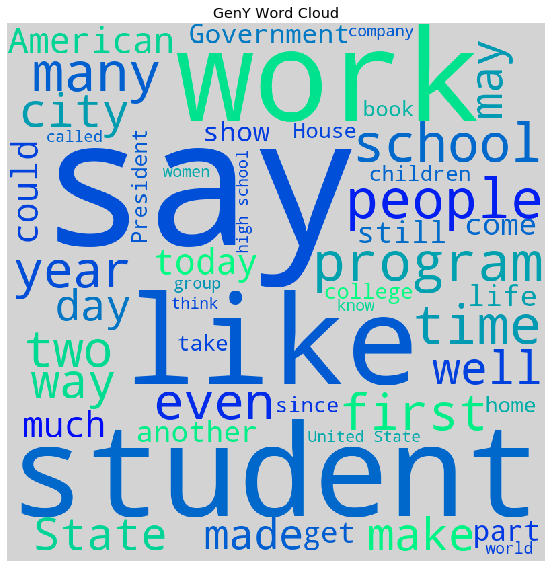

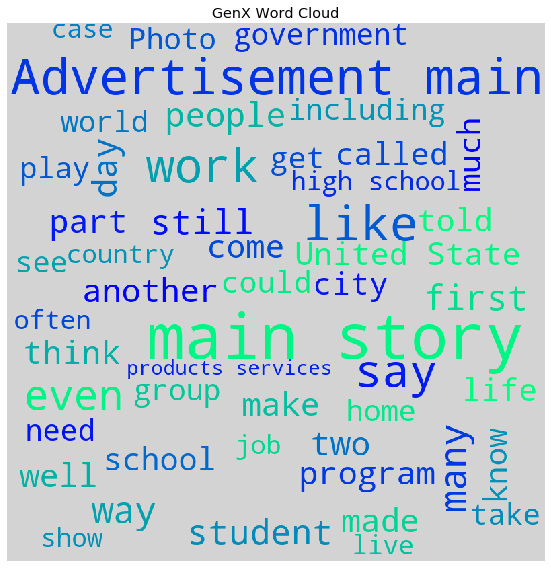

In [73]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,max_words=50,
                colormap='winter',
                background_color ='lightgray', 
                stopwords = stop_words, 
                min_font_size = 10).generate(bm)
  
# plot the WordCloud image                        
figure = plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.title('Boomer Word Cloud')
plt.axis("off") 
plt.tight_layout() 
figure.savefig('Word Cloud Boomer.png',dpi=300)
plt.show()

wordcloud = WordCloud(width = 800, height = 800,max_words=50,
                colormap='winter',
                background_color ='lightgray', 
                stopwords = stop_words, 
                min_font_size = 10).generate(X)
  
# plot the WordCloud image                        
figure = plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.title('GenX Word Cloud')
plt.axis("off") 
plt.tight_layout() 
figure.savefig('Word Cloud GenX.png',dpi=300)
plt.show() 

wordcloud = WordCloud(width = 800, height = 800,max_words=50,
                colormap='winter',
                background_color ='lightgray', 
                stopwords = stop_words, 
                min_font_size = 10).generate(Y)
  
# plot the WordCloud image                        
figure = plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.title('GenY Word Cloud')
plt.axis("off") 
plt.tight_layout() 
figure.savefig('Word Cloud GenY.png',dpi=300)
plt.show() 

wordcloud = WordCloud(width = 800, height = 800,max_words=50,
                colormap='winter',
                background_color ='lightgray', 
                stopwords = stop_words, 
                min_font_size = 10).generate(Z)
  
# plot the WordCloud image                        
figure = plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.title('GenX Word Cloud')
plt.axis("off") 
plt.tight_layout() 
figure.savefig('Word Cloud GenZ.png',dpi=300)
plt.show() 